Load the data

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import NMF

from sklearn.cluster import KMeans

from sklearn.metrics import r2_score

import warnings
warnings.simplefilter('ignore')

np.random.seed(0)

dow_jones = pd.read_csv("dow_jones_index.data")

V = dow_jones.pivot(index = "stock", columns = "date", values = "close")

V = V.replace('[\$,]', '', regex=True).astype(float)

V = V.T
V.head()

stock,AA,AXP,BA,BAC,CAT,CSCO,CVX,DD,DIS,GE,...,MRK,MSFT,PFE,PG,T,TRV,UTX,VZ,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
1/14/2011,15.97,46.25,70.07,15.25,94.01,21.21,92.83,49.80,39.29,18.82,...,34.23,28.30,18.34,65.53,28.43,54.63,79.08,35.46,54.81,77.84
1/21/2011,15.79,46.00,71.68,14.25,92.75,20.72,93.78,48.35,39.74,19.74,...,33.90,28.02,18.36,65.91,28.33,55.00,80.20,34.95,55.73,78.98
1/28/2011,16.13,43.86,69.23,13.60,95.68,20.93,93.37,50.29,38.85,20.20,...,33.07,27.75,18.15,64.20,27.49,55.81,81.43,35.63,56.70,78.99
1/7/2011,16.42,44.36,69.38,14.25,93.73,20.97,91.19,49.76,39.45,18.43,...,37.35,28.60,18.34,64.50,28.85,53.33,79.08,35.93,54.08,75.59
2/11/2011,17.37,46.75,72.14,14.77,103.54,18.70,96.45,54.58,43.41,21.33,...,33.07,27.25,18.83,64.73,28.47,58.99,85.20,36.39,55.69,82.82


Loop over values for the number of components/latent features.

Inside the outer loop we repeat the experiment 30 or so times to get an average reading of the r2 score. NMF uses random initialisation so we can sometimes get odd results.

In [5]:
k_range = [int(k) for k in np.linspace(1, 30, 30)]

error_list = list()

n_tests = 30

print("Running...")

for i in k_range:

    local_scores = list()
    
    for j in range(n_tests):
    
        model = NMF(n_components=i, init='random', max_iter=10000)
    
        W = model.fit_transform(V)
    
        H = model.components_
        
        reco = np.dot(W, H)
        
        error = r2_score(V, reco)
        
        local_scores.append(error)
    
    error_list.append(np.sum(local_scores)/n_tests)

print("Done")

Running...
Done


Plot the average r2 wrt to the number of latent features

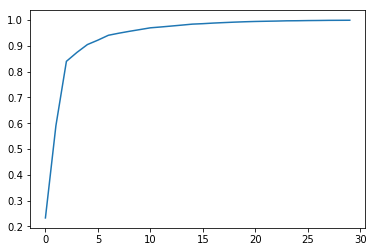

In [6]:
fig = plt.figure()
plt.plot(error_list)
fig

Plot the difference of r2 (see where biggest changes in r2 are)

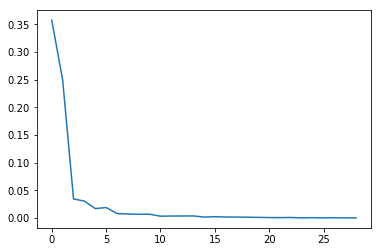

In [7]:
d = np.diff(error_list)
fig = plt.figure()
plt.plot(d)
fig

Use the elbow method to pick the optimal number of components and then display the cluster assignment

In [8]:
# Use elbow method
best_k = k_range[np.argmax(d) + 1]

model = NMF(n_components=best_k, init='random', max_iter=10000)
W = model.fit_transform(V)
H = model.components_

print("Optimal Number of Components: {0}".format(best_k))

# kmeans treats row as training example, so transpose H
kmeans = KMeans(n_clusters=best_k, random_state=0).fit(H.T)
# generate clustering labels for each training example
labels = kmeans.labels_

groups = [list() for i in range(best_k)]

for i in range(len(labels)):
    g = labels[i]
    groups[g].append(V.columns[i])

for i in range(len(groups)):
    print("Stock group {0}: ".format(i) + str(groups[i]))

Optimal Number of Components: 2
Stock group 0: ['AA', 'AXP', 'BAC', 'CSCO', 'DD', 'DIS', 'GE', 'HD', 'HPQ', 'INTC', 'JNJ', 'JPM', 'KO', 'KRFT', 'MRK', 'MSFT', 'PFE', 'PG', 'T', 'TRV', 'VZ', 'WMT']
Stock group 1: ['BA', 'CAT', 'CVX', 'IBM', 'MCD', 'MMM', 'UTX', 'XOM']


Use the min explained variance method

In [9]:
min_var = 0.95
valid_k_inds = [i for i, v in enumerate(error_list) if v >= min_var]

best_k = k_range[valid_k_inds[0]]

model = NMF(n_components=best_k, init='random', max_iter=10000)
W = model.fit_transform(V)
H = model.components_

print("Optimal Number of Components: {0}".format(best_k))

# kmeans treats row as training example, so transpose H
kmeans = KMeans(n_clusters=best_k, random_state=0).fit(H.T)
# generate clustering labels for each training example
labels = kmeans.labels_

groups = [list() for i in range(best_k)]

for i in range(len(labels)):
    g = labels[i]
    groups[g].append(V.columns[i])

for i in range(len(groups)):
    print("Stock group {0}: ".format(i) + str(groups[i]))

Optimal Number of Components: 9
Stock group 0: ['BA', 'JNJ', 'MMM', 'WMT']
Stock group 1: ['BAC', 'GE', 'HD', 'KRFT', 'MRK', 'PFE', 'T']
Stock group 2: ['IBM']
Stock group 3: ['CSCO', 'KO', 'MSFT']
Stock group 4: ['XOM']
Stock group 5: ['CAT', 'HPQ', 'JPM', 'VZ']
Stock group 6: ['AA', 'AXP', 'DD', 'DIS', 'INTC', 'TRV']
Stock group 7: ['CVX', 'UTX']
Stock group 8: ['MCD', 'PG']
